# Feature Selection



<i> We fit the date with models LinearRegressor, Lasso, Ridge and KNeighborsRegressor and compare the model performances.</i>
    
 **CONTENTS:**   <br>
      </p>
        -  <br>

        
**Insight:**
- 

        
 
        



## Imports and utilities

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_rows = 40
import warnings

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso,Ridge
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score



warnings.simplefilter(action='ignore', category=FutureWarning)

In [222]:
from skimpy import clean_columns
from nltk.metrics import edit_distance

class Cleaner:
    def __init__(self, df):

        self.cdf = clean_columns(df,case='snake')
        self.numerics_df =  self.cdf.select_dtypes(include=[np.number])
        self.numeric_cols = self.numerics_df.columns.values
        self.cats_df =   self.cdf.select_dtypes(include=object)
        self.cat_cols = self.cats_df.columns.values

    def drop_dups(self):
        df = self.cdf
        df_dedupped = df.drop_duplicates()
        # there were duplicate rows
        print('Dropping {} duplicates'.format(df.shape[0] - df_dedupped.shape[0]))
        df = df_dedupped

    def drop_select_dups(self, keys):
        #df.fillna(-999).groupby(keys)['id'].count().sort_values(ascending=False).head(20)
        self.cdf = self.cdf.drop_duplicates(subset=keys)

    def show_missing(self):
        for col in self.cdf.columns:
            pct_missing = np.mean(self.cdf[col].isnull())
            print('{} - {}%'.format(col, round(pct_missing*100)))

    def drop_missing(self, replace=False):
        df = self.cdf
        # first create missing indicator for features with missing data
        for col in df.columns:
            missing = df[col].isnull()
            num_missing = np.sum(missing)
            if num_missing > 0:
                print('created missing indicator for: {}'.format(col))
                df['{}_ismissing'.format(col)] = missing

            if replace == True:
                # categorical
                if col in set(self.numeric_cols):
                    print('Numerical column '+col+' has missing values.')
                    filler = input('Input a filler value (e.g. -999).')
                    df[col] = df[col].fillna(filler).astype(int)
                else:
                    print('Categorical column '+col+' has missing values.')
                    filler = input('Input a filler value (e.g. _MISSING_). ')
                    df[col] = df[col].fillna(filler)

        if replace == False:
            from math import ceil
            cut_off = ceil(0.50*len(df.columns)) # if a row is missing more than 10% of its entries drop it
            ismissing_cols = [col for col in df.columns if 'ismissing' in col]
            df['num_missing'] = df[ismissing_cols].sum(axis=1)
            # drop rows with a lot of missing values.
            ind_missing = df[df['num_missing'] > cut_off].index
            df = df.drop(ind_missing, axis=0)

    def impute_numerics(self):
        df = self.cdf
        for col in self.numeric_cols:
            missing = df[col].isnull()
            num_missing = np.sum(missing)

            if num_missing > 0:  # only do the imputation for the columns that have missing values.
                print('imputing missing values for: {}'.format(col))
                #df['{}_ismissing'.format(col)] = missing
                med = df[col].median()
                df[col] = df[col].fillna(med)

    def impute_cats(self):
        df = self.cdf
        for col in self.cat_cols:
            missing = df[col].isnull()
            num_missing = np.sum(missing)

            if num_missing > 0:  # only do the imputation for the columns that have missing values.
                print('imputing missing values for: {}'.format(col))
                #df['{}_ismissing'.format(col)] = missing
                top = df[col].describe()['top'] # impute with the most frequent value.
                df[col] = df[col].fillna(top)

    def redundants(self):
        df = self.cdf
        num_rows = len(df.index)
        low_information_cols = [] #

        for col in df.columns:
            cnts = df[col].value_counts(dropna=False)
            top_pct = (cnts/num_rows).iloc[0]

            if top_pct > 0.95:
                low_information_cols.append(col)
                print('{0}: {1:.5f}%'.format(col, top_pct*100))
                print(cnts)
                print()


    def col_rename(self, dict_rules):
        ''' rename columns in data frame using a dictionary of rules  '''
        if isinstance(dict_rules,dict):
            self.cdf.rename(columns = dict_rules, inplace=True)
        else:
            raise TypeError

    def expand_timestamp(self, time_colname):
        df = self.cdf
        df['timestamp_dt'] = pd.to_datetime(df[time_colname], format='%Y-%m-%d')
        df['year'] = df['timestamp_dt'].dt.year
        df['month'] = df['timestamp_dt'].dt.month
        df['weekday'] = df['timestamp_dt'].dt.weekday

        print(df['year'].value_counts(dropna=False))
        print()
        print(df['month'].value_counts(dropna=False))

    def get_typos(self,colname, word):
        tmp = pd.DataFrame([])
        tmp[colname] = self.cdf[colname]
        cn = 'distance_'+word
        tmp[cn] = self.cdf[colname].map(lambda x: edit_distance(x, word))
        return tmp.value_counts()

    def fix_typos(self,colname, word, dist=2):
        tmp = self.cdf.copy()
        tmp[colname] = self.cdf[colname]
        cn = 'distance_'+word
        tmp[cn] = self.cdf[colname].map(lambda x: edit_distance(x, word))
        msk = tmp[cn] <= dist
        self.cdf.loc[msk, colname] = word

    def row_string_replace(self, colname, replacement_dict):
        self.cdf[colname] = self.cdf[colname].replace(replacement_dict)



### Read and clean the data

In [56]:
c_df = pd.read_csv('../Data/Data_Marketing_Customer_Analysis_Round3.csv') # precleaned data

In [57]:
c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10689 entries, 0 to 10688
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Unnamed: 0                     10689 non-null  int64 
 1   region                         10689 non-null  object
 2   customer_lifetime_value        10689 non-null  int64 
 3   response                       10689 non-null  object
 4   coverage                       10689 non-null  object
 5   education                      10689 non-null  object
 6   effective_to_date              10689 non-null  object
 7   month                          10689 non-null  object
 8   employment_status              10689 non-null  object
 9   gender                         10689 non-null  object
 10  income                         10689 non-null  int64 
 11  location_code                  10689 non-null  object
 12  marital_status                 10689 non-null  object
 13  m

In [58]:
c_df.drop(labels=['Unnamed: 0'],axis=1,inplace=True) # drop the unnamed field

In [59]:
numerics_df   = c_df.select_dtypes(include=np.number) # get numerical columns using the select_dtypes method
cats_df       = c_df.select_dtypes(include=object)    # get non-numeric columns

Remove outliers

In [60]:
len(numerics_df.columns)

8

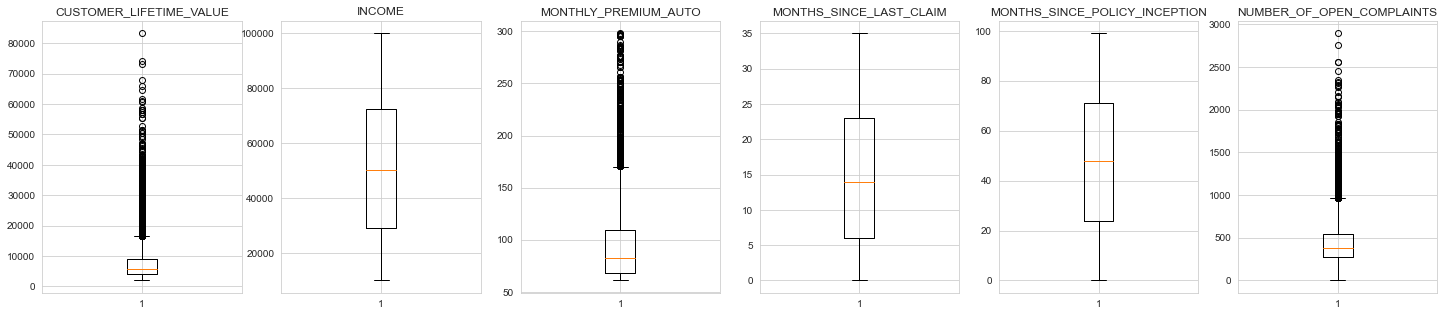

In [61]:
fig, ax = plt.subplots(1,6, figsize = (25,5))

for i in range(1,7):
    plt.subplot(1,6,i)
    plt.boxplot(numerics_df.drop(['number_of_open_complaints','number_of_policies'],axis=1).iloc[:,i-1])
    plt.title(f'{numerics_df.columns[i-1].upper()}')

In [62]:
def outlier_mask(df):
    """ returns a df of boolean values to used to index a trimmed table in the 1.5*IQR range"""
    q1 = df.quantile(0.05)
    q3 = df.quantile(0.95)
    iqr = q3 - q1
    return  ~((df < (q1 -  1.5*iqr)) |(df > (q3 + 1.5*iqr)))

In [63]:
cols_to_trim = list(numerics_df.drop(['monthly_premium_auto'],axis=1).columns)
cols_to_trim

['customer_lifetime_value',
 'income',
 'months_since_last_claim',
 'months_since_policy_inception',
 'number_of_open_complaints',
 'number_of_policies',
 'total_claim_amount']

In [64]:
# boolean index list of "inliers"
inliers = outlier_mask(numerics_df[cols_to_trim]).all(1)
# select subset of the data
numerics_df = numerics_df[inliers]

In [65]:
c_df = pd.concat([cats_df, numerics_df],axis=1)

In [66]:
clnr = Cleaner(c_df)

0 column names have been cleaned

In [67]:
clnr.impute_numerics()

imputing missing values for: customer_lifetime_value
imputing missing values for: income
imputing missing values for: monthly_premium_auto
imputing missing values for: months_since_last_claim
imputing missing values for: months_since_policy_inception
imputing missing values for: number_of_open_complaints
imputing missing values for: number_of_policies
imputing missing values for: total_claim_amount


In [68]:
c_df = clnr.cdf

In [69]:
X = c_df.drop(['monthly_premium_auto'],axis=1)
y = c_df['monthly_premium_auto']

In [70]:
y.shape

(10689,)

In [71]:
c_df.isnull().sum()

region                           0
response                         0
coverage                         0
education                        0
effective_to_date                0
month                            0
employment_status                0
gender                           0
location_code                    0
marital_status                   0
policy_type                      0
policy                           0
renew_offer_type                 0
sales_channel                    0
vehicle_class                    0
vehicle_size                     0
customer_lifetime_value          0
income                           0
monthly_premium_auto             0
months_since_last_claim          0
months_since_policy_inception    0
number_of_open_complaints        0
number_of_policies               0
total_claim_amount               0
dtype: int64

In [72]:
X.drop(['effective_to_date'],axis=1,inplace=True)

In [73]:
TEST_SIZE = 0.30
RANDOM_STATE = 32 # reproduce the same results. disables randomization

## Linear Regression Model

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,random_state=RANDOM_STATE)

In [75]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3207 entries, 6003 to 7247
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   region                         3207 non-null   object 
 1   response                       3207 non-null   object 
 2   coverage                       3207 non-null   object 
 3   education                      3207 non-null   object 
 4   month                          3207 non-null   object 
 5   employment_status              3207 non-null   object 
 6   gender                         3207 non-null   object 
 7   location_code                  3207 non-null   object 
 8   marital_status                 3207 non-null   object 
 9   policy_type                    3207 non-null   object 
 10  policy                         3207 non-null   object 
 11  renew_offer_type               3207 non-null   object 
 12  sales_channel                  3207 non-null 

In [76]:
cols_to_hot_encode = ['gender', 'marital_status', 'month', 'response', 'region', 'vehicle_class', 'renew_offer_type', 'policy_type', 'policy', 'location_code', 'sales_channel', 'coverage', 'education', 'employment_status', 'vehicle_size','vehicle_size']


In [77]:
col_to_standardize = ['customer_lifetime_value','income','total_claim_amount']

In [78]:
transformer = ColumnTransformer([
    ('standardize', StandardScaler(), col_to_standardize),
    ('encode', OneHotEncoder(), cols_to_hot_encode)
], remainder = 'passthrough', verbose_feature_names_out=True)

transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardize', StandardScaler(),
                                 ['customer_lifetime_value', 'income',
                                  'total_claim_amount']),
                                ('encode', OneHotEncoder(),
                                 ['gender', 'marital_status', 'month',
                                  'response', 'region', 'vehicle_class',
                                  'renew_offer_type', 'policy_type', 'policy',
                                  'location_code', 'sales_channel', 'coverage',
                                  'education', 'employment_status',
                                  'vehicle_size', 'vehicle_size'])])

In [79]:
transformer.get_feature_names_out()

array(['standardize__customer_lifetime_value', 'standardize__income',
       'standardize__total_claim_amount', 'encode__gender_f',
       'encode__gender_m', 'encode__marital_status_divorced',
       'encode__marital_status_married', 'encode__marital_status_single',
       'encode__month_feb', 'encode__month_jan', 'encode__response_no',
       'encode__response_yes', 'encode__region_central',
       'encode__region_east', 'encode__region_north west',
       'encode__region_west region',
       'encode__vehicle_class_four-door car',
       'encode__vehicle_class_luxury car',
       'encode__vehicle_class_luxury suv',
       'encode__vehicle_class_sports car', 'encode__vehicle_class_suv',
       'encode__vehicle_class_two-door car',
       'encode__renew_offer_type_offer1',
       'encode__renew_offer_type_offer2',
       'encode__renew_offer_type_offer3',
       'encode__renew_offer_type_offer4',
       'encode__policy_type_corporate auto',
       'encode__policy_type_personal auto',
 

In [80]:
# std. transformed and encoded variables (np arrays)
X_train_e = transformer.transform(X_train)
X_test_e  = transformer.transform(X_test)

In [81]:
X_train_e_df = pd.DataFrame(X_train_e,columns=transformer.get_feature_names_out())
X_test_e_df = pd.DataFrame(X_test_e,columns=transformer.get_feature_names_out())

In [82]:
### GET RESULTS
def tableResults2(result):
    table_results = pd.DataFrame(result.tables[0].data)
    table_results = table_results.iloc[:,2:4].T
    table_results.columns = table_results.iloc[0]
    table_results = float(table_results.iloc[1,0])
    return table_results
### GET R SQUARED
def getR2(result):
    table_results = pd.DataFrame(result.tables[0].data)
    table_results = table_results.iloc[:,2:4].T
    table_results.columns = table_results.iloc[0]
    table_results = float(table_results.iloc[1,0])
    return table_results

#### Correlations 

In [83]:
numerics_df.corr()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
customer_lifetime_value,1.000000,-0.000816,0.377913,0.008586,0.015356,-0.028507,0.025269,0.207638
income,-0.000816,1.000000,-0.011652,-0.018325,0.011350,0.012641,-0.001512,-0.120968
monthly_premium_auto,0.377913,-0.011652,1.000000,0.003199,0.017092,-0.002034,-0.014827,0.621229
months_since_last_claim,0.008586,-0.018325,0.003199,1.000000,-0.038136,-0.001685,0.007205,0.005755
months_since_policy_inception,0.015356,0.011350,0.017092,-0.038136,1.000000,0.004957,-0.009393,-0.000472
number_of_open_complaints,-0.028507,0.012641,-0.002034,-0.001685,0.004957,1.000000,0.002767,-0.006887
number_of_policies,0.025269,-0.001512,-0.014827,0.007205,-0.009393,0.002767,1.000000,-0.003770
total_claim_amount,0.207638,-0.120968,0.621229,0.005755,-0.000472,-0.006887,-0.003770,1.000000


##### HEATMAP 

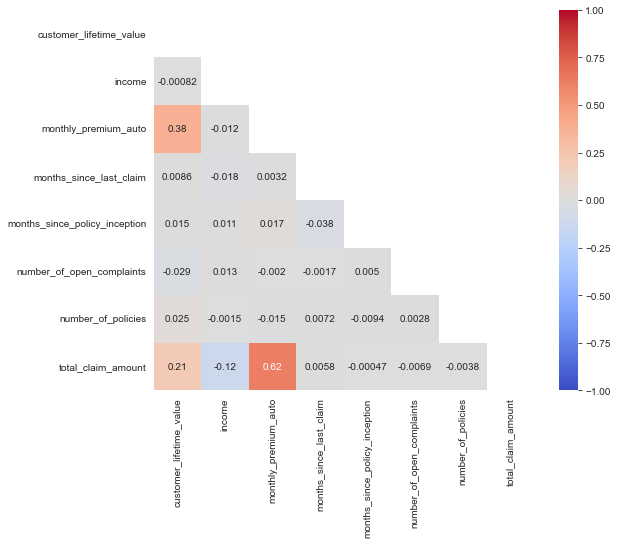

In [84]:
n_corr = numerics_df.corr()
mask = np.zeros_like(n_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(n_corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

#### Observations
- Negligible multicolinearity in the data
- Modest correlation (r=approx .6) between total_claim_amount and monthly_premium_auto. Customer_lifetime_value is moderatedly correlated (r=.4) with monthly_premium_auto and total_claim_amount (r=.25) as well. The months_since_last_claim and monthly_premium_auto are expected to be anticorrelated, but this is not observed.


#### Highly Correlated Columns (absence of)

In [85]:
corr_thresh    =  0.9
corr_abs       = n_corr.abs()
upper_triangle = corr_abs.where(np.triu(np.ones(corr_abs.shape),k=1).astype(bool))
[column for column in upper_triangle.columns if any(upper_triangle[column] > corr_thresh)]

[]

### Apply linear regression model

In [86]:
model = LinearRegression()           # model
model.fit(X_train_e, y_train)   # model train
y_pred       = model.predict(X_test_e)   # model prediction [test]
y_pred_train = model.predict(X_train_e)  # model prediction [train]
result = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

In [112]:
lm = LinearRegression()

selector = RFE(lm, n_features_to_select=40, step = 1, verbose = 1) # Step is how many features to add or drop everytime
selector.fit(X_train_e_df, y_train)

kept_features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train_e_df.iloc[:,kept_features].columns)

X_train_s = selector.transform(X_train_e_df)
X_test_s  = selector.transform(X_test_e_df)

X_train_s_df = pd.DataFrame(X_train_s, columns=kept_features)
X_test_s_df  = pd.DataFrame(X_test_s, columns=kept_features)

Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 fe

In [113]:
model.fit(X_train_s, y_train)   # model train
y_pred_s       = model.predict(X_test_s)   # model prediction [test]
y_pred_s_train = model.predict(X_train_s)  # model prediction [train]
result = pd.DataFrame({"y_test":y_test,"y_pred":y_pred_s})
print(f"{model.__class__.__name__}: Train -> {model.score(X_train_s, y_train)}, Test -> {model.score(X_test_s, y_test)}")

LinearRegression: Train -> 0.8599568829117378, Test -> 0.8654406559296112


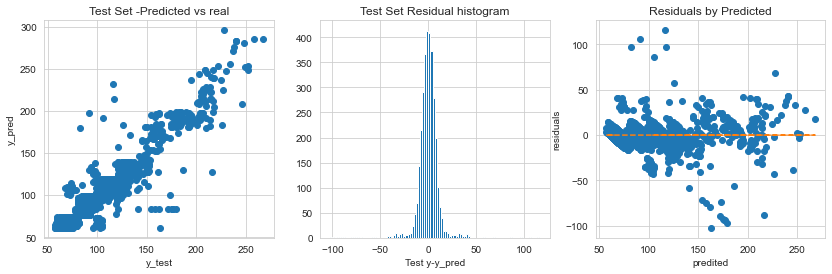

In [119]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred, 100)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

In [36]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

123.74490754705911
6.584742185368432


In [37]:
R2    = r2_score(y_test,y_pred)
mse_o = mse(y_test,y_pred)
mae_o = mae(y_test,y_pred)
print(R2, mse_o,mae_o)


0.8913744420967546 123.74490754705911 6.584742185368432


In [38]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train_e_df.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

features_importances

,Attribute,Importance
39,encode__location_code_suburban,3.514057e+11
40,encode__location_code_urban,3.514057e+11
38,encode__location_code_rural,3.514057e+11
45,encode__coverage_basic,1.911539e+11
46,encode__coverage_extended,1.911539e+11
...,...,...
66,remainder__number_of_open_complaints,3.801270e-01
1,standardize__income,5.466672e-02
67,remainder__number_of_policies,3.244019e-02
64,remainder__months_since_last_claim,1.065063e-02


In [162]:
sm.add_constant(X_train_e_df)

,const,standardize__customer_lifetime_value,standardize__income,standardize__total_claim_amount,encode__gender_f,encode__gender_m,encode__marital_status_divorced,encode__marital_status_married,encode__marital_status_single,encode__month_feb,...,encode__vehicle_size_large,encode__vehicle_size_medsize,encode__vehicle_size_small,encode__vehicle_size_large,encode__vehicle_size_medsize,encode__vehicle_size_small,remainder__months_since_last_claim,remainder__months_since_policy_inception,remainder__number_of_open_complaints,remainder__number_of_policies
0,1.0,-0.797035,-1.002805,-0.313201,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,4.0,41.0,0.0,1.0
1,1.0,0.600597,-0.416653,-1.451874,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,28.0,69.0,0.0,2.0
2,1.0,0.398894,-0.441393,-0.127509,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,6.0,17.0,0.0,2.0
3,1.0,-0.508138,1.494704,1.137294,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,23.0,32.0,0.0,7.0
4,1.0,-0.822923,-1.016709,-0.768670,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,32.0,20.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7477,1.0,0.358077,-1.598877,0.496133,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,18.0,84.0,0.0,2.0
7478,1.0,-0.062166,1.390446,0.040664,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,27.0,26.0,0.0,3.0
7479,1.0,3.007225,1.283478,-1.462385,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,34.0,80.0,0.0,2.0
7480,1.0,0.487199,-0.900219,0.797444,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,14.0,78.0,0.0,7.0


In [173]:
y_train.reset_index(drop=True)

0        71.0
1        73.0
2        89.0
3        70.0
4        66.0
        ...  
7477     90.0
7478     92.0
7479     74.0
7480    137.0
7481     67.0
Name: monthly_premium_auto, Length: 7482, dtype: float64

In [174]:
X_train_const_scaled = sm.add_constant(X_train_e_df) #adding a constant

ols = sm.OLS(y_train.reset_index(drop=True), X_train_const_scaled).fit()
predictions_train = ols.predict(X_train_const_scaled)

X_test_const_scaled = sm.add_constant(X_test_e_df) #adding a constant
predictions_test = ols.predict(X_test_const_scaled)

print_model = ols.summary()
print(print_model)

                             OLS Regression Results                             
Dep. Variable:     monthly_premium_auto   R-squared:                       0.888
Model:                              OLS   Adj. R-squared:                  0.887
Method:                   Least Squares   F-statistic:                     1228.
Date:                  Fri, 21 Oct 2022   Prob (F-statistic):               0.00
Time:                          01:16:38   Log-Likelihood:                -28775.
No. Observations:                  7482   AIC:                         5.765e+04
Df Residuals:                      7433   BIC:                         5.799e+04
Df Model:                            48                                         
Covariance Type:              nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [175]:
print_model.tables[0]


Dep. Variable:,monthly_premium_auto,R-squared:,0.888
Model:,OLS,Adj. R-squared:,0.887
Method:,Least Squares,F-statistic:,1228.
Date:,"Fri, 21 Oct 2022",Prob (F-statistic):,0.00
Time:,01:16:38,Log-Likelihood:,-28775.
No. Observations:,7482,AIC:,5.765e+04
Df Residuals:,7433,BIC:,5.799e+04
Df Model:,48,,
Covariance Type:,nonrobust,,


In [176]:
print_model.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,23.0442,0.111,206.864,0.000,22.826,23.263
standardize__customer_lifetime_value,1.4623,0.142,10.289,0.000,1.184,1.741
standardize__income,0.0546,0.151,0.362,0.717,-0.241,0.350
standardize__total_claim_amount,10.1903,0.249,40.856,0.000,9.701,10.679
encode__gender_f,11.8248,0.142,83.425,0.000,11.547,12.103
encode__gender_m,11.2194,0.147,76.552,0.000,10.932,11.507
encode__marital_status_divorced,8.5169,0.264,32.244,0.000,7.999,9.035
encode__marital_status_married,8.6944,0.192,45.268,0.000,8.318,9.071
encode__marital_status_single,5.8329,0.240,24.317,0.000,5.363,6.303
encode__month_feb,11.7411,0.144,81.418,0.000,11.458,12.024


In [204]:
low_ps = ols.params[list(np.where(ols.pvalues < 0.05)[0])].iloc[1:].index
#low_ps.pop(0)
low_ps


Index(['standardize__customer_lifetime_value',
       'standardize__total_claim_amount', 'encode__gender_f',
       'encode__gender_m', 'encode__marital_status_divorced',
       'encode__marital_status_married', 'encode__marital_status_single',
       'encode__month_feb', 'encode__month_jan', 'encode__response_no',
       'encode__response_yes', 'encode__region_central', 'encode__region_east',
       'encode__region_north west', 'encode__region_west region',
       'encode__vehicle_class_four-door car',
       'encode__vehicle_class_luxury car', 'encode__vehicle_class_luxury suv',
       'encode__vehicle_class_sports car', 'encode__vehicle_class_suv',
       'encode__vehicle_class_two-door car', 'encode__renew_offer_type_offer1',
       'encode__renew_offer_type_offer2', 'encode__renew_offer_type_offer3',
       'encode__renew_offer_type_offer4', 'encode__policy_type_corporate auto',
       'encode__policy_type_personal auto', 'encode__policy_type_special auto',
       'encode__policy_

In [206]:
low_ps.shape

(63,)

In [213]:
cols_drop = list( set(X_train_e_df.columns)-set(low_ps) )

In [218]:
X_train_s_df = X_train_e_df.drop(cols_drop,axis=1)
X_test_s_df =  X_test_e_df.drop(cols_drop,axis=1)

In [221]:
X_train_s_df.shape

(7482, 63)

In [220]:
model=LinearRegression()
model.fit(X_train_s_df, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train_s_df, y_train)}, Test -> {model.score(X_test_s_df, y_test)}")



LinearRegression: Train -> 0.8877922342453447, Test -> 0.8909475585193906


In [130]:
lass = Lasso(alpha=0.05)

lass.fit(X_train_e, y_train)
print(f"{lass.__class__.__name__}: Train -> {lass.score(X_train_e, y_train)}, Test -> {lass.score(X_test_e, y_test)}")

Lasso: Train -> 0.8872919089961652, Test -> 0.8913279471456887


In [132]:
lass.alpha

0.05

In [136]:
#print("Best alpha using built-in LassoCV: %f" % lass.alpha)
print("Best score using built-in LassoCV: %f" %lass.score(X_train_e,y_train))
coef = pd.Series(lass.coef_, index = X_train_e_df.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best score using built-in LassoCV: 0.887292
Lasso picked 36 variables and eliminated the other 32 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

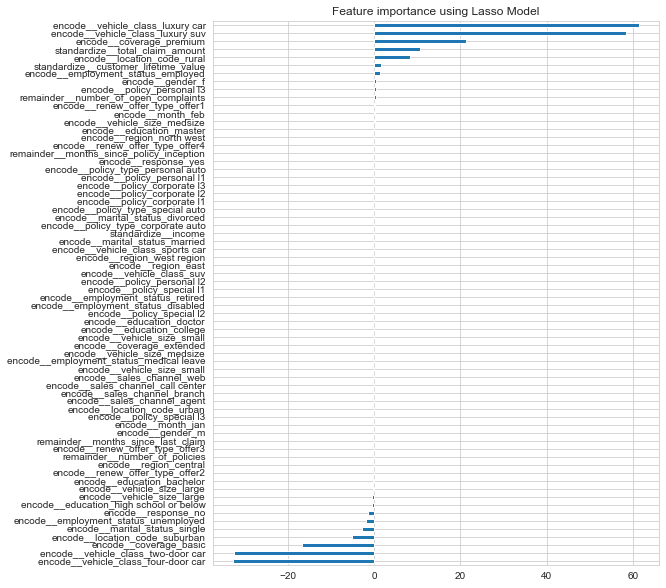

In [137]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [149]:
imp_coef_df=imp_coef.to_frame(name='reg_coeff')

In [150]:
imp_mask=imp_coef_df['reg_coeff']==0

In [157]:
unimportant_features = imp_coef_df[imp_mask].index.to_list()
print('Features with vanishing lasso regularization coefficients: ')
display(unimportant_features)

Features with vanishing lasso regularization coefficients: 


['encode__policy_special l3',
 'encode__location_code_urban',
 'encode__sales_channel_agent',
 'encode__sales_channel_branch',
 'encode__sales_channel_call center',
 'encode__sales_channel_web',
 'encode__vehicle_size_small',
 'encode__employment_status_medical leave',
 'encode__vehicle_size_medsize',
 'encode__coverage_extended',
 'encode__vehicle_size_small',
 'encode__education_college',
 'encode__education_doctor',
 'encode__policy_special l2',
 'encode__employment_status_disabled',
 'encode__employment_status_retired',
 'encode__policy_special l1',
 'encode__policy_personal l2',
 'encode__vehicle_class_suv',
 'encode__region_east',
 'encode__region_west region',
 'encode__vehicle_class_sports car',
 'encode__marital_status_married',
 'standardize__income',
 'encode__policy_type_corporate auto',
 'encode__marital_status_divorced',
 'encode__policy_type_special auto',
 'encode__policy_corporate l1',
 'encode__policy_corporate l2',
 'encode__policy_corporate l3',
 'encode__policy_per

These coefficients are not important

In [46]:
model=Ridge(alpha=0.05)
model.fit(X_train_e, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train_e, y_train)}, Test -> {model.score(X_test_e, y_test)}")

Ridge: Train -> 0.8880069880464028, Test -> 0.8913743583156623


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = X_train.select_dtypes(include=np.number)
X_test  = X_test.select_dtypes(include=np.number)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

nulls = pd.DataFrame(X_train.isna().sum()).reset_index()
nulls.columns = ['Column','nas']
nulls.head()
nulls[nulls['nas'] > 0].head()
cols_to_drop = nulls[nulls['nas'] > 0]['Column'] # Too drastic, but made on pourpose for quick filtering (don't do this in production!!)

X_train.drop(columns=cols_to_drop, axis=1, inplace = True)
X_test.drop(columns=cols_to_drop, axis=1, inplace = True)

#display(X_train)

lm = LinearRegression()

selector = RFE(lm, n_features_to_select=20, step = 1, verbose = 1) # Step is how many features to add or drop everytime
selector.fit(X_train, y_train)

kept_features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train.iloc[:,kept_features].columns)

X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

X_train = pd.DataFrame(X_train, columns=kept_features)
X_test  = pd.DataFrame(X_test, columns=kept_features)


In [53]:
print("Final selected features: ")
display(X_train)

Final selected features: 


,customer_lifetime_value,income,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,21423.0,88733.0,9.0,31.0,0.0,2.0,312.0
1,8391.0,40211.0,5.0,98.0,2.0,6.0,710.0
2,3969.0,49544.0,3.0,29.0,0.0,1.0,0.0
3,14914.0,45963.0,3.0,73.0,2.0,2.0,302.0
4,18060.0,57882.0,1.0,61.0,0.0,2.0,552.0
...,...,...,...,...,...,...,...
8546,7610.0,98701.0,22.0,66.0,0.0,3.0,79.0
8547,35186.0,86134.0,17.0,78.0,0.0,2.0,3.0
8548,4241.0,19834.0,26.0,8.0,4.0,8.0,460.0
8549,12941.0,77060.0,23.0,90.0,0.0,2.0,468.0
